# 01-数据加载模块

下面展示数据加载模块的效果，这里以下载 NVDA 股票的数据为例

In [1]:
import os
import sys

# 将项目根目录添加到 python 路径中
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from scripts.data_loader import DataLoader

loader = DataLoader()
# 抓取 NVIDIA 的数据作为练习
df = loader.fetch_and_save("NVDA", "2023-01-01", "2024-01-01")

In [2]:
# 检查数据质量
df

Price,Close,High,Low,Open,Volume
Date,,,,,
2023-01-03,14.300682,14.981002,14.081901,14.836146,401277000.0
2023-01-04,14.734250,14.838146,14.226759,14.552433,431324000.0
2023-01-05,14.250736,14.549437,14.133853,14.476510,389168000.0
2023-01-06,14.844139,14.994988,14.019964,14.459524,405044000.0
2023-01-09,15.612371,16.039943,15.125858,15.268716,504231000.0
...,...,...,...,...,...
2023-12-22,48.802814,49.355504,48.440014,49.167609,252507000.0
2023-12-26,49.251556,49.572377,48.932734,48.940729,244200000.0
2023-12-27,49.389488,49.652342,49.057672,49.483438,233648000.0


下面，我们来检查一下下载的数据

In [3]:
# 检查是否有缺失交易日
print(f"缺失值统计:\n{df.isnull().sum()}")

# 检查数据重复
print(f"重复行数: {df.duplicated().sum()}")

缺失值统计:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
重复行数: 0


## 数据处理

下面,我们将原始数据转换成带有信号的"加工数据".

In [4]:
from scripts.indicators import IndicatorAppender
import pandas as pd

# 1. 获取刚刚下载的数据
df_raw = pd.read_csv('../storage/raw/NVDA_20230101_20240101.csv', index_col=0, parse_dates=True)

# 2. 加工数据
appender = IndicatorAppender()
df_processed = appender.add_trend_indicators(df_raw)
df_processed = appender.add_momentum_indicators(df_processed)

# 3. 观察结果
df_processed.tail()

,Close,High,Low,Open,Volume,SMA_20,SMA_60,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,
2023-12-22,48.802814,49.355504,48.440014,49.167609,252507000.0,47.704328,46.059671,55.352132,0.634318,0.069911,0.564407
2023-12-26,49.251556,49.572377,48.932734,48.940729,244200000.0,47.756361,46.156015,57.245958,0.655653,0.072997,0.582656
2023-12-27,49.389488,49.652342,49.057672,49.483438,233648000.0,47.836328,46.233287,57.837947,0.675900,0.074596,0.601305
2023-12-28,49.494427,49.856225,49.384487,49.615362,246587000.0,47.905601,46.333379,58.310896,0.692432,0.072902,0.619530
2023-12-29,49.494427,49.969165,48.723856,49.785265,389293000.0,48.043329,46.424742,58.310896,0.697493,0.062371,0.635123


## 生成信号

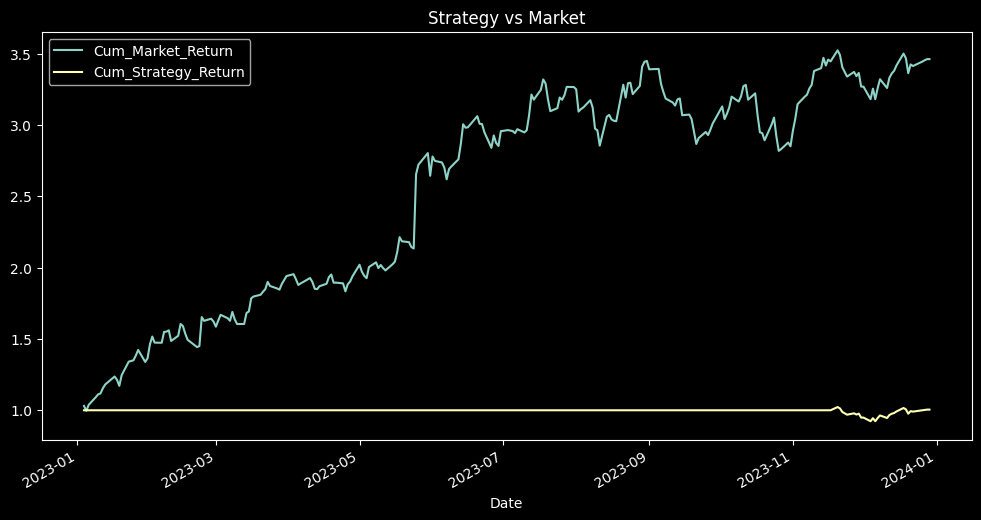

In [6]:
from scripts.strategy import SimpleStrategy

# 1. 生成信号
strategy = SimpleStrategy()
df_final = strategy.generate_signals(df_processed)

# 2. 计算收益率
# 计算每日市场涨跌幅
df_final['Market_Return'] = df_final['Close'].pct_change()
# 计算策略收益率 (今天的持仓状态 * 明天的涨跌幅)
df_final['Strategy_Return'] = df_final['Position'].shift(1) * df_final['Market_Return']

# 3. 计算累计收益并对比
df_final['Cum_Market_Return'] = (1 + df_final['Market_Return']).cumprod()
df_final['Cum_Strategy_Return'] = (1 + df_final['Strategy_Return']).cumprod()

# 4. 可视化
df_final[['Cum_Market_Return', 'Cum_Strategy_Return']].plot(figsize=(12, 6), title="Strategy vs Market")

## 评测结果

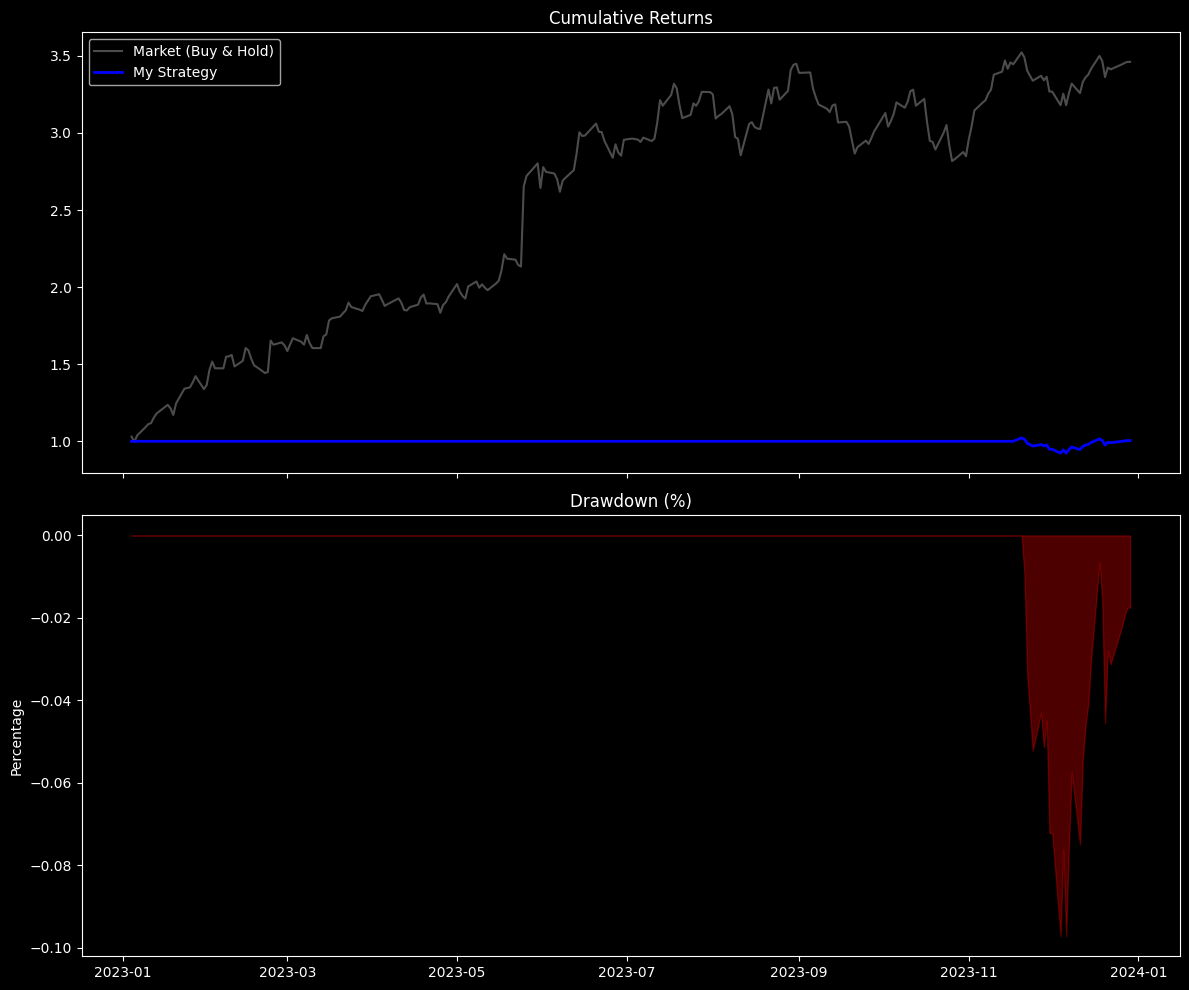

In [7]:
from scripts.analytics import StrategyAnalytics
import matplotlib.pyplot as plt

# 1. 计算指标
analytics = StrategyAnalytics()
metrics, drawdown_series = analytics.calculate_performance(df_final)

# 2. 打印结果
print("--- 策略表现评价 ---")
for k, v in metrics.items():
    print(f"{k}: {v}")

# 3. 绘制双图对比
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 图1：累计收益对比
ax1.plot(df_final['Cum_Market_Return'], label='Market (Buy & Hold)', color='gray', alpha=0.6)
ax1.plot(df_final['Cum_Strategy_Return'], label='My Strategy', color='blue', linewidth=2)
ax1.set_title('Cumulative Returns')
ax1.legend()

# 图2：回撤区域图
ax2.fill_between(drawdown_series.index, drawdown_series, 0, color='red', alpha=0.3)
ax2.set_title('Drawdown (%)')
ax2.set_ylabel('Percentage')

plt.tight_layout()
plt.show()